# Model Development 

In [61]:
#Import Relevant Libraries
import cv2, os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageOps
from tqdm import tqdm
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as T

In [47]:
images_folder = "./ds/images/"
masks_folder = "./ds/masks/"

print(f'Total number of images: {len(os.listdir(images_folder))}')
print(f'Total number of image masks: {len(os.listdir(masks_folder))}')


Total number of images: 10
Total number of image masks: 10


./ds/images/43216_SAFP039486.jpeg
./ds/images/42967_SAFP064689.jpeg
./ds/images/43762_SBFF002526.jpeg
./ds/images/43573_RCFN000006.jpeg


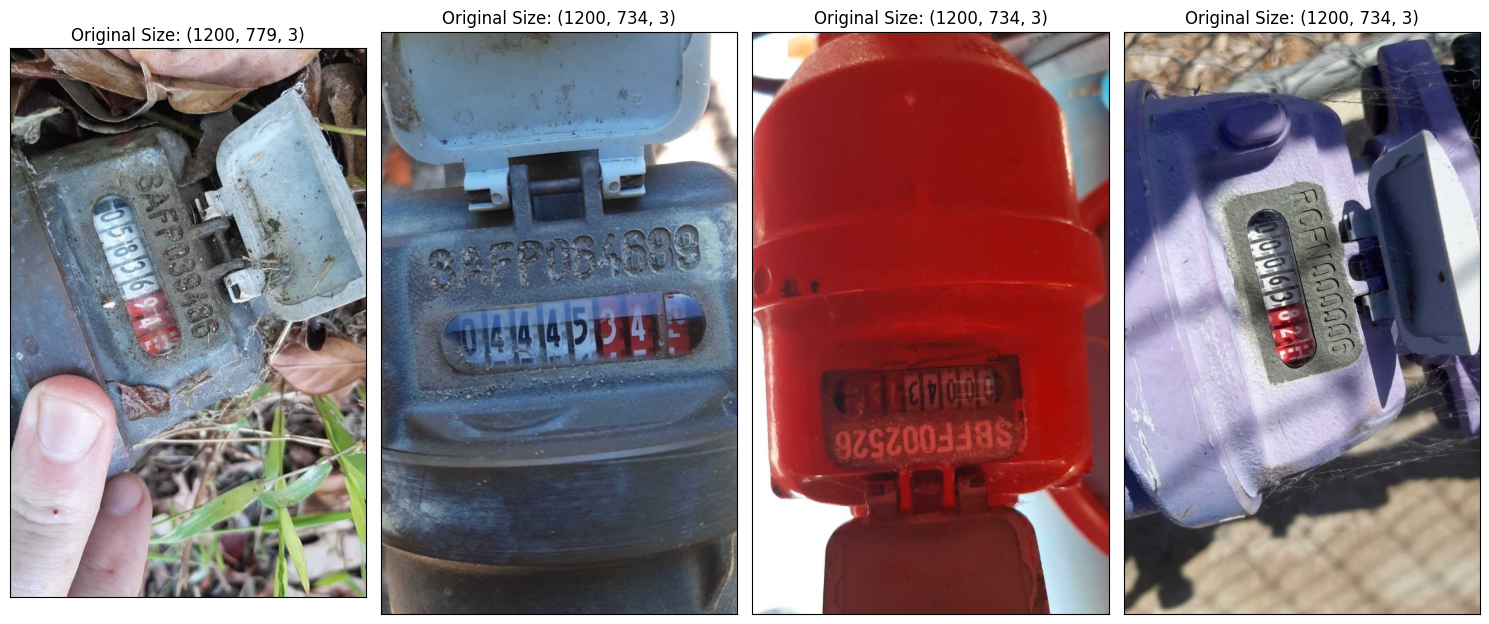

In [52]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    file = os.listdir(images_folder)[a]
    image_path = os.path.join(images_folder, file) 
    img = cv2.imread(image_path)
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title) 
    img = img[:,:,::-1]
    plt.imshow(img)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

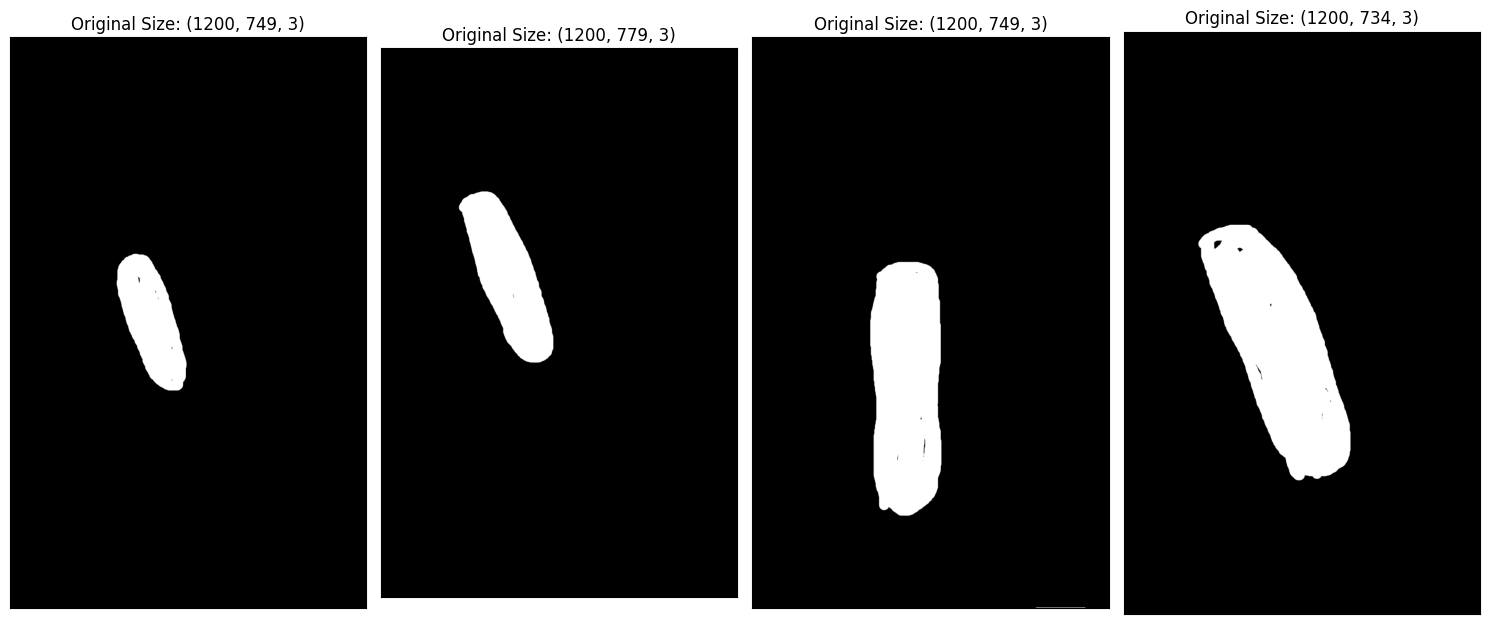

In [53]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir(masks_folder)[a]
    image_path = os.path.join(masks_folder, file) 
    img = cv2.imread(image_path)  
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title) 
    img = img[:,:,::-1]
    plt.imshow(img)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

In [55]:
def plot_seg_imgs(images_folder, masks_folder, name):
 
    # Get the list of image and mask filenames
    image_files = sorted(os.listdir(images_folder))[:4]  # Select the first 4 images
    mask_files = sorted(os.listdir(masks_folder))[:4]  # Select the first 4 masks

    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 rows (images and masks), 4 columns

    for i in range(4):
        # Read and process the image
        img_path = os.path.join(images_folder, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        # Read and process the corresponding mask
        mask_path = os.path.join(masks_folder, mask_files[i])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale mask

        # Display the image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{name} Image #{i}")
        axes[0, i].axis('off')

        # Display the mask
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f"{name} Mask #{i}")
        axes[1, i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()


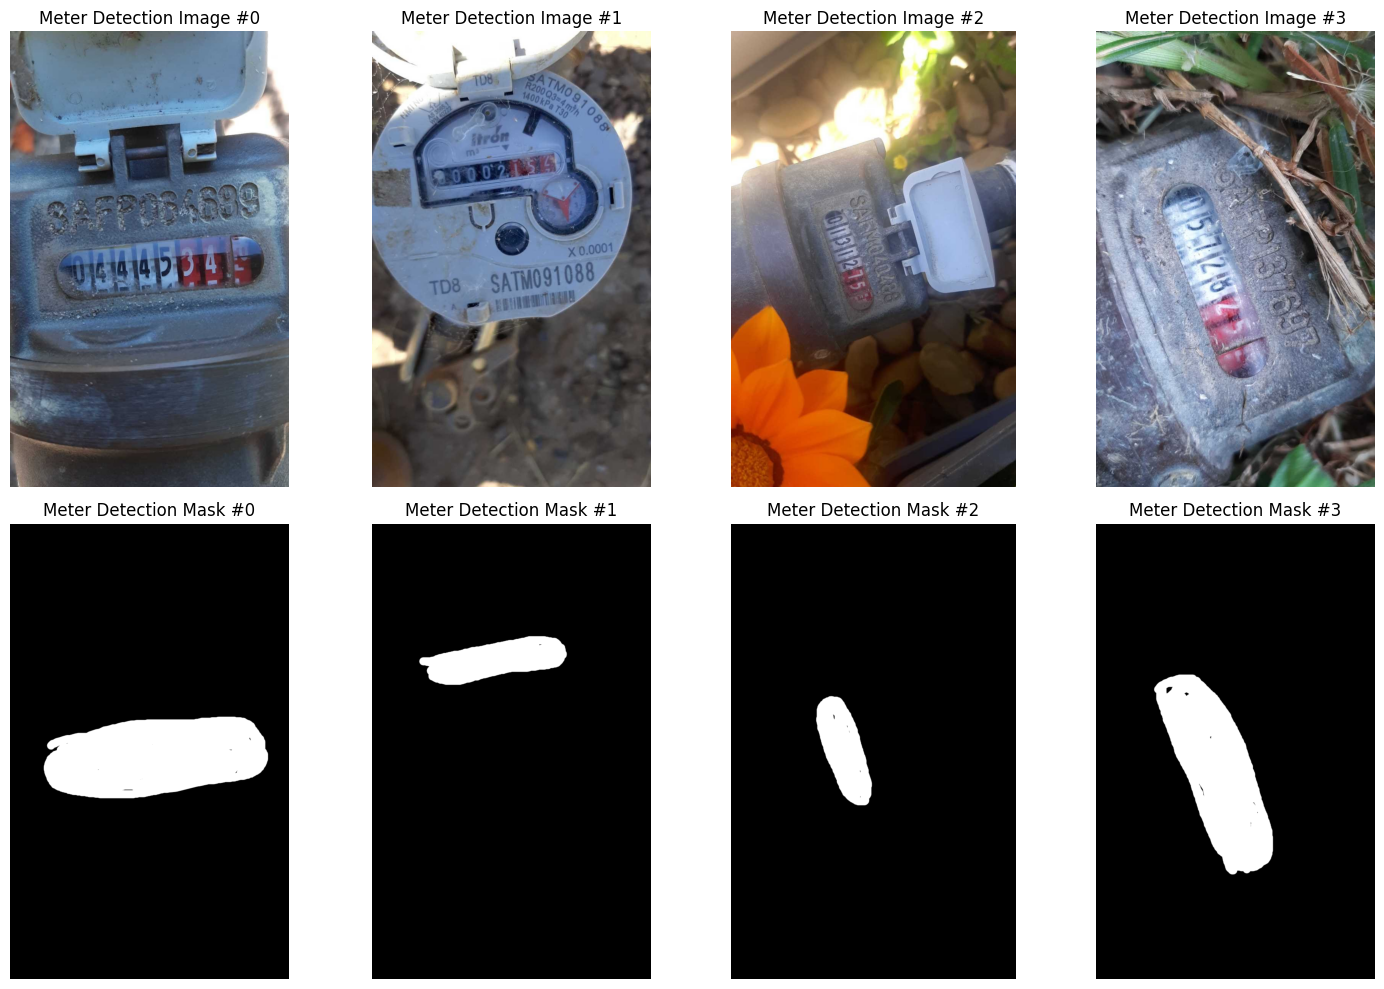

In [57]:
#Print first 4 resized meter, resized mask, and collage images.
plot_seg_imgs(images_folder,masks_folder,"Meter Detection")



In [59]:
#Create function to crop images.
def crop(img, bg, mask) -> np.array:
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image


#Crop training images using supplied masks.
if os.path.exists('./cropped_for_ocr') == False:
    os.mkdir('cropped_for_ocr')
else:
    pass

ocr_path = './cropped_for_ocr'

for n, image, mask in tqdm(zip(range(len(os.listdir(images_folder))), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)
    
    #Read images and masks.
    img = cv2.imread(dir_img).astype('uint8')
    mask = cv2.imread(dir_mask).astype('uint8')
    
    #Get dimensions of image.
    h, w, _ = img.shape
    
    #Ensure mask is binary, and create black background in shape of image.
    mask = cv2.resize(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), (w, h)) # Resize image
    bg = np.zeros_like(img, 'uint8') # Black background

    #Crop image based on mask and make it RBG.
    New_image = crop(img,bg,mask)
    New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)

    #Extract portion of image where meter reading is.
    #Use min and max x and y coordinates to obtain final image.
    where = np.array(np.where(New_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = New_image.astype('uint8')[x1:x2, y1:y2]

    #Write image to file
    cv2.imwrite(os.path.join(ocr_path , image), sub_image)

10it [00:00, 52.73it/s]


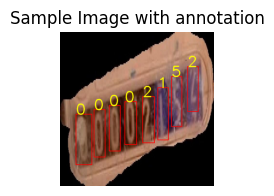

In [60]:
import os
import cv2
import matplotlib.pyplot as plt

# Folder paths
image_folder = "./ocr/train/images"  # Path to the folder containing images
label_folder = "./ocr/train/labels"  # Path to the folder containing label files

# Function to parse a label file
def parse_label_file(label_file):
    bboxes = []
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])  # Class label
            coords = list(map(float, parts[1:]))  # Normalized coordinates
            bboxes.append((cls, coords))
    return bboxes

# Function to draw bounding boxes
def draw_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    h, w, _ = image.shape
    
    bboxes = parse_label_file(label_path)
    
    for cls, coords in bboxes:
        # Extract and rescale coordinates
        x_center, y_center, x1, y1, x2, y2, x3, y3, x4, y4 = coords
        points = [
            (int(x1 * w), int(y1 * h)),
            (int(x2 * w), int(y2 * h)),
            (int(x3 * w), int(y3 * h)),
            (int(x4 * w), int(y4 * h)),
        ]
        
        # Draw the bounding box (polygon)
        for i in range(len(points)):
            start_point = points[i]
            end_point = points[(i + 1) % len(points)]  # Connect back to the first point
            cv2.line(image, start_point, end_point, (255, 0, 0), 2)  # Blue bounding box
        
        # Display class label
        cv2.putText(image, str(cls), points[0], cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 3)  # Green text
    
    return image

# Visualize images with bounding boxes
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))


image_path = os.path.join(image_folder, image_files[1])
label_path = os.path.join(label_folder, label_files[1])
    
# Draw bounding boxes
result_image = draw_bboxes(image_path, label_path)

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(result_image)
plt.axis("off")
plt.title(f"Sample Image with annotation")
plt.show()


In [24]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.transforms = transforms

        if len(self.image_files) != len(self.label_files):
            print(f"Warning: {len(self.image_files)} images and {len(self.label_files)} labels found.")

    def __len__(self):
        return min(len(self.image_files), len(self.label_files))

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load image and annotations
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        with open(label_path, 'r') as f:
            annotations = f.readlines()

        boxes = []
        labels = []

        for annotation in annotations:
            parts = annotation.strip().split()
            cls = int(parts[0])
            coords = list(map(float, parts[1:]))

            x_coords = [coords[i] for i in range(0, len(coords), 2)]
            y_coords = [coords[i] for i in range(1, len(coords), 2)]
            x_coords = [int(x * w) for x in x_coords]
            y_coords = [int(y * h) for y in y_coords]
            x_min, y_min = min(x_coords), min(y_coords)
            x_max, y_max = max(x_coords), max(y_coords)

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(cls)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            image = self.transforms(image)
        return image, target


In [25]:

# Load pre-trained Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 9 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [35]:

# Define transforms
transforms = T.Compose([
    T.ToTensor(),  # Converts image to PyTorch tensor
])

# Load dataset
image_dir = "./ocr/train/images"
label_dir = "./ocr/train/labels"
dataset = CustomDataset(image_dir, label_dir, transforms=transforms)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Set up optimizer
device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")


Epoch 1, Loss: 2.7571545094251633
Epoch 2, Loss: 2.598223716020584
Epoch 3, Loss: 2.637656405568123
Epoch 4, Loss: 2.517558217048645
Epoch 5, Loss: 2.2465718388557434
Epoch 6, Loss: 2.042969584465027
Epoch 7, Loss: 1.9603371322154999
Epoch 8, Loss: 1.8801539167761803
Epoch 9, Loss: 2.1806444972753525
Epoch 10, Loss: 2.8000621497631073
Epoch 11, Loss: 2.1538428366184235
Epoch 12, Loss: 2.161502316594124
Epoch 13, Loss: 1.7626128420233727
Epoch 14, Loss: 1.685069479048252
Epoch 15, Loss: 1.551038734614849
Epoch 16, Loss: 1.8659437000751495
Epoch 17, Loss: 1.4662330150604248
Epoch 18, Loss: 1.2028040364384651
Epoch 19, Loss: 1.16996368765831
Epoch 20, Loss: 1.3357464149594307


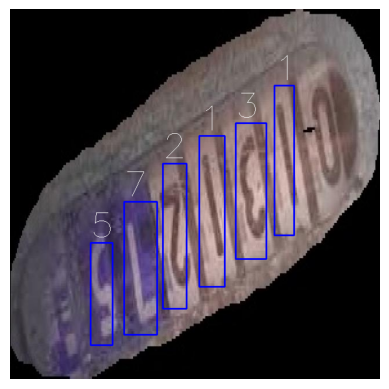

In [74]:
model.eval()

# Visualize predictions on a test image
test_image_path = "./ocr/test/images/43107_SAFM040488_jpeg.rf.9df6159968cf159f6858433500533517.jpg"
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_tensor = T.ToTensor()(test_image_rgb).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    predictions = model(test_tensor)

# Draw predictions
boxes = predictions[0]['boxes'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()
for i, box in enumerate(boxes):
    if scores[i] > 0.4:  # Confidence threshold
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(test_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(test_image, str(labels[i]), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 1)

# Display the image
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [37]:
torch.save(model.state_dict(), "faster_rcnn_model_new.pth")
